In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

from scipy.io import arff

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression

from mlproject.helperfunc import *

# EEG Data

In [157]:
data = arff.loadarff('data/eeg/EEG Eye State.arff')

In [158]:
df = pd.DataFrame(data[0])

df.eyeDetection = df.eyeDetection.astype('int32')

df = df.rename(columns = {'eyeDetection' : 'y'})

df = df.sample(frac = 1).reset_index(drop = True)

X = df.iloc[:, :-1]
y = df.y

df

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,y
0,4275.90,3966.15,4262.56,4107.18,4325.13,4607.18,4051.79,4622.56,4201.03,4235.38,4198.97,4260.00,4589.23,4343.59,0
1,4306.15,3995.90,4281.54,4149.23,4345.13,4632.31,4057.95,4622.56,4209.74,4224.62,4203.08,4288.72,4593.85,4350.77,0
2,4300.51,4000.00,4261.54,4120.00,4344.62,4622.05,4059.49,4614.36,4199.49,4229.23,4198.97,4273.85,4603.59,4352.31,0
3,4246.15,3981.03,4237.95,4105.64,4341.03,4616.92,4073.85,4602.05,4190.77,4216.41,4179.49,4258.97,4562.56,4295.90,0
4,4277.44,3986.67,4248.21,4121.03,4316.92,4615.38,4043.59,4599.49,4187.18,4218.46,4189.23,4265.13,4603.08,4334.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4260.00,3988.72,4238.46,4104.62,4337.95,4603.08,4062.05,4589.23,4176.41,4209.23,4174.87,4258.97,4593.33,4328.21,1
14976,4277.95,3973.85,4263.59,4106.15,4329.74,4615.90,4078.46,4635.38,4206.15,4223.59,4197.44,4285.13,4571.79,4342.05,0
14977,4311.79,4030.26,4263.59,4124.62,4350.26,4631.79,4098.46,4617.95,4218.46,4237.95,4209.74,4288.21,4604.62,4358.97,0
14978,4300.51,4014.36,4264.10,4127.69,4335.38,4618.46,4086.15,4601.54,4200.00,4245.64,4207.69,4283.59,4601.03,4344.62,1


In [159]:
scaler = RobustScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
scaled_df = X
scaled_df['y'] = y

In [160]:
scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,y
0,-0.590153,-1.222222,0.000000,-0.553112,-0.899285,-0.723790,-0.720359,0.473819,0.083424,0.324025,-0.073264,-0.868138,-0.519310,-0.366591,0
1,0.376918,-0.301455,0.925402,1.191701,0.400260,0.965054,-0.480109,0.473819,0.555255,-0.242887,0.122265,0.605439,-0.346082,-0.133247,0
2,0.196611,-0.174559,-0.049732,-0.021162,0.367122,0.275538,-0.420047,0.052875,0.000000,0.000000,-0.073264,-0.157517,0.019123,-0.083198,0
3,-1.541240,-0.761684,-1.199902,-0.617012,0.133853,-0.069220,0.140016,-0.579055,-0.472373,-0.675448,-1.000000,-0.920985,-1.519310,-1.916477,0
4,-0.540921,-0.587125,-0.699659,0.021577,-1.432749,-0.172715,-1.040172,-0.710472,-0.666847,-0.567439,-0.536632,-0.604926,0.000000,-0.666558,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,-1.098465,-0.523677,-1.175037,-0.659336,-0.066277,-0.999328,-0.320203,-1.237166,-1.250271,-1.053741,-1.219791,-0.920985,-0.365579,-0.866428,1
14976,-0.524616,-0.983906,0.050219,-0.595851,-0.599740,-0.137769,0.319813,1.131930,0.360780,-0.297155,-0.146051,0.421242,-1.173228,-0.416640,0
14977,0.557225,0.761993,0.050219,0.170539,0.733593,0.930108,1.099844,0.237166,1.027627,0.459431,0.439106,0.579271,0.057743,0.133247,0
14978,0.196611,0.269885,0.075085,0.297925,-0.233268,0.034274,0.619735,-0.605236,0.027627,0.864594,0.341579,0.342227,-0.076865,-0.333117,1


In [6]:
eeg_svm_train_df, eeg_svm_test_df = run_svm(scaled_df)

In [7]:
eeg_svm_train_df

,accuracy,f1,auc
0,0.9738,0.970098,0.972822
1,0.9746,0.995434,0.995838
2,0.9740,0.971328,0.973305
3,0.9742,0.970365,0.973209
4,0.9744,0.970803,0.973416


In [8]:
eeg_svm_test_df

,accuracy,f1,auc
0,0.933659,0.926224,0.932405
1,0.935481,0.926254,0.932731
2,0.934669,0.926389,0.933285
3,0.929157,0.921064,0.927620
4,0.935403,0.927551,0.933782


In [9]:
eeg_rf_train_df, eeg_rf_test_df = run_random_forest(scaled_df)

In [10]:
eeg_rf_train_df

,accuracy,f1,auc
0,0.9852,0.983360,0.983518
1,0.9850,0.983243,0.983742
2,0.9824,0.979638,0.980729
3,0.9834,0.979991,0.980611
4,0.9842,0.981720,0.985026


In [11]:
eeg_rf_test_df

,accuracy,f1,auc
0,0.866425,0.843829,0.859795
1,0.865014,0.835973,0.856985
2,0.868627,0.841701,0.861119
3,0.859282,0.829471,0.850576
4,0.866499,0.845341,0.861133


In [12]:
eeg_lg_train_df, eeg_lg_test_df = run_log_reg(scaled_df)

In [13]:
eeg_lg_train_df

,accuracy,f1,auc
0,0.6344,0.552838,0.623541
1,0.6526,0.576857,0.642066
2,0.6410,0.562088,0.629575
3,0.6600,0.566105,0.643958
4,0.6426,0.558220,0.630185


In [14]:
eeg_lg_test_df

,accuracy,f1,auc
0,0.634142,0.537096,0.618930
1,0.640484,0.555619,0.627182
2,0.630738,0.541426,0.617067
3,0.641406,0.545540,0.626472
4,0.634687,0.540534,0.620261


In [18]:
eeg_svm_train_df['CLF'] = 'SVM'
eeg_svm_test_df['CLF'] = 'SVM'

eeg_rf_train_df['CLF'] = 'rf'
eeg_rf_test_df['CLF'] = 'rf'

eeg_lg_train_df['CLF'] = 'LogReg'
eeg_lg_test_df['CLF'] = 'LogReg'

In [25]:
eeg_comb_train_df = pd.concat([eeg_svm_train_df, eeg_rf_train_df, eeg_lg_train_df])
eeg_comb_train_df

,accuracy,f1,auc,CLF
0,0.9738,0.970098,0.972822,SVM
1,0.9746,0.995434,0.995838,SVM
2,0.9740,0.971328,0.973305,SVM
3,0.9742,0.970365,0.973209,SVM
4,0.9744,0.970803,0.973416,SVM
0,0.9852,0.983360,0.983518,rf
1,0.9850,0.983243,0.983742,rf
2,0.9824,0.979638,0.980729,rf
3,0.9834,0.979991,0.980611,rf
4,0.9842,0.981720,0.985026,rf


In [29]:
grouped_eeg_train = eeg_comb_train_df.groupby('CLF').mean()
grouped_eeg_train

,accuracy,f1,auc
CLF,,,
LogReg,0.64612,0.563222,0.633865
SVM,0.97420,0.975606,0.977718
rf,0.98404,0.981590,0.982725


In [34]:
grouped_eeg_train.to_csv('raw_out/grouped_eeg_train.csv')

In [30]:
eeg_comb_test_df = pd.concat([eeg_svm_test_df, eeg_rf_test_df, eeg_lg_test_df])
eeg_comb_test_df

,accuracy,f1,auc,CLF
0,0.933659,0.926224,0.932405,SVM
1,0.935481,0.926254,0.932731,SVM
2,0.934669,0.926389,0.933285,SVM
3,0.929157,0.921064,0.927620,SVM
4,0.935403,0.927551,0.933782,SVM
0,0.866425,0.843829,0.859795,rf
1,0.865014,0.835973,0.856985,rf
2,0.868627,0.841701,0.861119,rf
3,0.859282,0.829471,0.850576,rf
4,0.866499,0.845341,0.861133,rf


In [31]:
grouped_eeg_test = eeg_comb_test_df.groupby('CLF').mean()
grouped_eeg_test

,accuracy,f1,auc
CLF,,,
LogReg,0.636291,0.544043,0.621982
SVM,0.933674,0.925496,0.931965
rf,0.865169,0.839263,0.857921


In [41]:
grouped_eeg_test.to_csv('raw_out/grouped_eeg_test.csv')

# Occupancy Data

In [57]:
data1 = pd.read_csv('data/occupancy_data/datatest.txt')
data2 = pd.read_csv('data/occupancy_data/datatest2.txt')
data3 = pd.read_csv('data/occupancy_data/datatraining.txt')

data = pd.concat([data1, data2, data3])

df = data.drop(columns = ['date'])

df = df.sample(frac = 1).reset_index(drop = True)

df = df.rename(columns = {'Occupancy' : 'y'})

X = df.iloc[:, :-1]
y = df.y

df

,Temperature,Humidity,Light,CO2,HumidityRatio,y
0,20.890000,30.290000,0.00,1193.000000,0.004628,0
1,20.100000,32.400000,0.00,505.666667,0.004716,0
2,20.790000,26.290000,0.00,1550.500000,0.003988,0
3,20.390000,18.700000,0.00,438.000000,0.002762,0
4,19.340000,26.840000,0.00,472.000000,0.003721,0
...,...,...,...,...,...,...
20555,22.180000,34.480000,444.25,1366.500000,0.005711,1
20556,20.267500,30.365000,0.00,707.000000,0.004464,0
20557,21.033333,19.533333,0.00,479.333333,0.003003,0
20558,22.340000,17.790000,337.75,457.500000,0.002963,0


In [60]:
scaler = RobustScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
scaled_df = X
scaled_df['y'] = y

In [61]:
scaled_df

,0,1,2,3,4,y
0,0.143396,0.441826,0.000000,1.820841,0.302362,0
1,-0.452830,0.752577,0.000000,-0.173356,0.381006,0
2,0.067925,-0.147275,0.000000,2.858075,-0.272729,0
3,-0.233962,-1.265096,0.000000,-0.369681,-1.374516,0
4,-1.026415,-0.066274,0.000000,-0.271035,-0.513372,0
...,...,...,...,...,...,...
20555,1.116981,1.058910,1.475914,2.324226,1.275643,1
20556,-0.326415,0.452872,0.000000,0.410783,0.154573,0
20557,0.251572,-1.142366,0.000000,-0.249758,-1.158009,0
20558,1.237736,-1.399116,1.122093,-0.313104,-1.194615,0


In [62]:
occ_svm_train_df, occ_svm_test_df = run_svm(scaled_df)

In [64]:
occ_svm_train_df

,accuracy,f1,auc
0,0.9920,0.983292,0.994865
1,0.9906,0.978665,0.993671
2,0.9902,0.979455,0.993959
3,0.9908,0.979965,0.993432
4,0.9884,0.975022,0.992189


In [65]:
occ_svm_test_df

,accuracy,f1,auc
0,0.989030,0.976572,0.990620
1,0.989799,0.978718,0.992599
2,0.987802,0.974096,0.992045
3,0.989695,0.978232,0.991519
4,0.990558,0.979995,0.993106


In [66]:
occ_rf_train_df, occ_rf_test_df = run_random_forest(scaled_df)

In [67]:
occ_rf_train_df

,accuracy,f1,auc
0,0.9880,0.973545,0.989397
1,0.9882,0.975345,0.991110
2,0.9878,0.972633,0.989556
3,0.9900,0.979027,0.991694
4,0.9874,0.972136,0.989645


In [68]:
occ_rf_test_df

,accuracy,f1,auc
0,0.986855,0.972302,0.988372
1,0.989033,0.976559,0.990989
2,0.986675,0.971914,0.986515
3,0.988571,0.975551,0.990208
4,0.986300,0.971145,0.985725


In [69]:
occ_lg_train_df, occ_lg_test_df = run_log_reg(scaled_df)

In [70]:
occ_lg_train_df

,accuracy,f1,auc
0,0.9888,0.976451,0.992706
1,0.9892,0.976127,0.991772
2,0.9870,0.972562,0.990033
3,0.9864,0.970228,0.988692
4,0.9916,0.982744,0.993333


In [71]:
occ_lg_test_df

,accuracy,f1,auc
0,0.988834,0.976228,0.990390
1,0.988722,0.976314,0.990706
2,0.989224,0.977117,0.991306
3,0.989451,0.977801,0.991548
4,0.988474,0.975390,0.990909


In [72]:
occ_svm_train_df['CLF'] = 'SVM'
occ_svm_test_df['CLF'] = 'SVM'

occ_rf_train_df['CLF'] = 'rf'
occ_rf_test_df['CLF'] = 'rf'

occ_lg_train_df['CLF'] = 'LogReg'
occ_lg_test_df['CLF'] = 'LogReg'

In [73]:
occ_comb_train_df = pd.concat([occ_svm_train_df, occ_rf_train_df, occ_lg_train_df])
occ_comb_train_df

,accuracy,f1,auc,CLF
0,0.9920,0.983292,0.994865,SVM
1,0.9906,0.978665,0.993671,SVM
2,0.9902,0.979455,0.993959,SVM
3,0.9908,0.979965,0.993432,SVM
4,0.9884,0.975022,0.992189,SVM
0,0.9880,0.973545,0.989397,rf
1,0.9882,0.975345,0.991110,rf
2,0.9878,0.972633,0.989556,rf
3,0.9900,0.979027,0.991694,rf
4,0.9874,0.972136,0.989645,rf


In [74]:
grouped_occ_train = occ_comb_train_df.groupby('CLF').mean()
grouped_occ_train

,accuracy,f1,auc
CLF,,,
LogReg,0.98860,0.975623,0.991307
SVM,0.99040,0.979280,0.993623
rf,0.98828,0.974537,0.990280


In [79]:
grouped_occ_train.to_csv('raw_out/grouped_occ_train.csv')

In [75]:
occ_comb_test_df = pd.concat([occ_svm_test_df, occ_rf_test_df, occ_lg_test_df])
occ_comb_test_df

,accuracy,f1,auc,CLF
0,0.989030,0.976572,0.990620,SVM
1,0.989799,0.978718,0.992599,SVM
2,0.987802,0.974096,0.992045,SVM
3,0.989695,0.978232,0.991519,SVM
4,0.990558,0.979995,0.993106,SVM
0,0.986855,0.972302,0.988372,rf
1,0.989033,0.976559,0.990989,rf
2,0.986675,0.971914,0.986515,rf
3,0.988571,0.975551,0.990208,rf
4,0.986300,0.971145,0.985725,rf


In [76]:
grouped_occ_test = occ_comb_test_df.groupby('CLF').mean()
grouped_occ_test

,accuracy,f1,auc
CLF,,,
LogReg,0.988941,0.976570,0.990972
SVM,0.989377,0.977523,0.991978
rf,0.987487,0.973494,0.988362


In [80]:
grouped_occ_test.to_csv('raw_out/grouped_occ_test.csv')

# League Data

In [81]:
df = pd.read_csv('data/league/high_diamond_ranked_10min.csv')
df = df.drop(columns = 'gameId')

df = df.sample(frac = 1).reset_index(drop = True)

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,16,1,0,2,6,0,0,0,0,...,0,16182,6.8,18648,241,32,2438,1929,24.1,1618.2
1,0,87,3,1,7,4,7,1,1,0,...,0,14155,6.2,14710,183,28,-2568,-3054,18.3,1415.5
2,1,17,3,1,8,5,8,2,1,1,...,0,15595,6.8,16417,209,45,-1928,-1805,20.9,1559.5
3,1,18,4,0,5,4,3,1,1,0,...,0,14563,6.2,16098,204,32,-733,-810,20.4,1456.3
4,1,18,2,1,10,11,13,0,0,0,...,0,17831,7.0,17849,208,40,384,1658,20.8,1783.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,0,19,4,0,5,10,6,1,0,1,...,0,17640,6.8,17233,197,51,2620,1037,19.7,1764.0
9875,1,24,2,1,6,5,6,0,0,0,...,0,16116,7.0,17384,221,45,245,278,22.1,1611.6
9876,0,13,0,0,9,5,7,1,1,0,...,0,15950,6.6,16205,213,52,-1372,-2320,21.3,1595.0
9877,0,14,3,0,7,8,9,0,0,0,...,0,17795,7.0,18185,231,52,1673,327,23.1,1779.5


In [82]:
scaler = RobustScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
scaled_df = X
scaled_df['y'] = y

In [83]:
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,y
0,0.000000,-0.666667,-1.0,-1.00,0.00,-1.2,0.0,0.0,0.0,0.0,...,-0.098443,-0.5,0.433441,0.766667,-1.461538,0.770706,0.759640,0.766667,-0.098443,0
1,11.833333,0.000000,0.0,0.25,-0.50,0.2,1.0,1.0,0.0,0.0,...,-1.116524,-2.0,-2.099035,-1.166667,-1.769231,-0.802766,-1.231568,-1.166667,-1.116524,0
2,0.166667,0.000000,0.0,0.50,-0.25,0.4,2.0,1.0,1.0,0.0,...,-0.393270,-0.5,-1.001286,-0.300000,-0.461538,-0.601603,-0.732468,-0.300000,-0.393270,1
3,0.333333,0.333333,-1.0,-0.25,-0.50,-0.6,1.0,1.0,0.0,0.0,...,-0.911602,-2.0,-1.206431,-0.466667,-1.461538,-0.225994,-0.334865,-0.466667,-0.911602,1
4,0.333333,-0.333333,0.0,1.00,1.25,1.4,0.0,0.0,0.0,0.0,...,0.729784,0.0,-0.080386,-0.333333,-0.846154,0.125098,0.651349,-0.333333,0.729784,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,0.500000,0.333333,-1.0,-0.25,1.00,0.0,1.0,0.0,1.0,0.0,...,0.633852,-0.5,-0.476527,-0.700000,0.000000,0.827911,0.403197,-0.700000,0.633852,0
9875,1.333333,-0.333333,0.0,0.00,-0.25,0.0,0.0,0.0,0.0,0.0,...,-0.131592,0.0,-0.379421,0.100000,-0.461538,0.081408,0.099900,0.100000,-0.131592,1
9876,-0.500000,-1.000000,-1.0,0.75,-0.25,0.2,1.0,1.0,0.0,0.0,...,-0.214967,-1.0,-1.137621,-0.166667,0.076923,-0.426843,-0.938262,-0.166667,-0.214967,0
9877,-0.333333,0.000000,-1.0,0.25,0.50,0.6,0.0,0.0,0.0,0.0,...,0.711703,0.0,0.135691,0.433333,0.076923,0.530253,0.119481,0.433333,0.711703,0


In [84]:
lea_svm_train_df, lea_svm_test_df = run_svm(scaled_df)

In [85]:
lea_svm_train_df

,accuracy,f1,auc
0,0.9964,0.996283,0.941811
1,0.8350,0.996153,0.735604
2,0.9960,0.996046,0.937131
3,0.9954,0.935724,0.936186
4,0.9952,0.995185,0.829403


In [86]:
lea_svm_test_df

,accuracy,f1,auc
0,0.626151,0.628761,0.651883
1,0.701103,0.630586,0.728625
2,0.631182,0.629630,0.653814
3,0.628433,0.656552,0.655050
4,0.627903,0.628895,0.704743


In [87]:
lea_rf_train_df, lea_rf_test_df = run_random_forest(scaled_df)

In [88]:
lea_rf_train_df

,accuracy,f1,auc
0,1.0000,1.0,1.000000
1,1.0000,1.0,1.000000
2,0.9998,1.0,0.999794
3,1.0000,1.0,1.000000
4,1.0000,1.0,1.000000


In [89]:
lea_rf_test_df

,accuracy,f1,auc
0,0.718348,0.717013,0.716674
1,0.723525,0.721799,0.724184
2,0.719363,0.714801,0.716774
3,0.717285,0.724508,0.715362
4,0.716537,0.711317,0.715437


In [90]:
lea_lg_train_df, lea_lg_test_df = run_log_reg(scaled_df)

In [91]:
lea_lg_train_df

,accuracy,f1,auc
0,0.7300,0.730324,0.729800
1,0.7318,0.727273,0.731715
2,0.7324,0.633634,0.730051
3,0.5006,0.667200,0.500000
4,0.7488,0.754304,0.500000


In [92]:
lea_lg_test_df

,accuracy,f1,auc
0,0.731190,0.732541,0.730681
1,0.726053,0.723080,0.726797
2,0.725034,0.629969,0.726513
3,0.497735,0.664650,0.500000
4,0.727608,0.728788,0.500000


In [93]:
lea_svm_train_df['CLF'] = 'SVM'
lea_svm_test_df['CLF'] = 'SVM'

lea_rf_train_df['CLF'] = 'rf'
lea_rf_test_df['CLF'] = 'rf'

lea_lg_train_df['CLF'] = 'LogReg'
lea_lg_test_df['CLF'] = 'LogReg'

In [94]:
lea_comb_train_df = pd.concat([lea_svm_train_df, lea_rf_train_df, lea_lg_train_df])
lea_comb_train_df

,accuracy,f1,auc,CLF
0,0.9964,0.996283,0.941811,SVM
1,0.8350,0.996153,0.735604,SVM
2,0.9960,0.996046,0.937131,SVM
3,0.9954,0.935724,0.936186,SVM
4,0.9952,0.995185,0.829403,SVM
0,1.0000,1.000000,1.000000,rf
1,1.0000,1.000000,1.000000,rf
2,0.9998,1.000000,0.999794,rf
3,1.0000,1.000000,1.000000,rf
4,1.0000,1.000000,1.000000,rf


In [95]:
grouped_lea_train = lea_comb_train_df.groupby('CLF').mean()
grouped_lea_train

,accuracy,f1,auc
CLF,,,
LogReg,0.68872,0.702547,0.638313
SVM,0.96360,0.983878,0.876027
rf,0.99996,1.000000,0.999959


In [96]:
grouped_lea_train.to_csv('raw_out/grouped_lea_train.csv')

In [97]:
lea_comb_test_df = pd.concat([lea_svm_test_df, lea_rf_test_df, lea_lg_test_df])
lea_comb_test_df

,accuracy,f1,auc,CLF
0,0.626151,0.628761,0.651883,SVM
1,0.701103,0.630586,0.728625,SVM
2,0.631182,0.629630,0.653814,SVM
3,0.628433,0.656552,0.655050,SVM
4,0.627903,0.628895,0.704743,SVM
0,0.718348,0.717013,0.716674,rf
1,0.723525,0.721799,0.724184,rf
2,0.719363,0.714801,0.716774,rf
3,0.717285,0.724508,0.715362,rf
4,0.716537,0.711317,0.715437,rf


In [98]:
grouped_lea_test = lea_comb_test_df.groupby('CLF').mean()
grouped_lea_test

,accuracy,f1,auc
CLF,,,
LogReg,0.681524,0.695806,0.636798
SVM,0.642954,0.634885,0.678823
rf,0.719011,0.717888,0.717686


In [99]:
grouped_lea_test.to_csv('raw_out/grouped_lea_test.csv')

# CSGO Data

In [150]:
df = pd.read_csv('data/csgo/csgo_round_snapshots.csv')

In [151]:
def conv_winner(winner):
    if winner == 'T':
        return 0
    elif winner == 'CT':
        return 1
    

df.round_winner = df.round_winner.apply(conv_winner)
df.bomb_planted = df.bomb_planted.astype('int32')

# One hot encode 'map'
df = pd.concat((df, pd.get_dummies(df.map)), 1)
df = df.drop(columns = ['map'])

df = df.sample(frac = 1).reset_index(drop = True)

In [152]:
y = df.round_winner
X = df.drop(columns = ['round_winner'])

df

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,t_grenade_decoygrenade,round_winner,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
0,94.91,9.0,11.0,0,500.0,179.0,499.0,200.0,11900.0,4450.0,...,0.0,1,0,0,0,0,0,0,0,1
1,114.91,8.0,7.0,0,500.0,500.0,400.0,300.0,700.0,550.0,...,0.0,0,0,0,0,0,0,0,1,0
2,94.95,7.0,9.0,0,260.0,500.0,200.0,500.0,400.0,1150.0,...,0.0,0,0,0,0,1,0,0,0,0
3,94.93,4.0,6.0,0,495.0,500.0,489.0,435.0,3850.0,17400.0,...,0.0,0,0,0,0,0,0,1,0,0
4,174.95,14.0,10.0,0,500.0,500.0,191.0,362.0,26850.0,19700.0,...,0.0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,94.93,1.0,4.0,0,408.0,367.0,496.0,397.0,10550.0,1800.0,...,0.0,0,0,0,0,0,1,0,0,0
122406,18.12,11.0,11.0,1,225.0,0.0,256.0,0.0,9000.0,0.0,...,0.0,1,0,0,0,1,0,0,0,0
122407,21.55,5.0,4.0,1,100.0,303.0,100.0,404.0,150.0,17950.0,...,0.0,0,0,0,0,0,0,1,0,0
122408,174.95,7.0,11.0,0,500.0,500.0,62.0,342.0,14200.0,19300.0,...,0.0,0,0,0,0,0,1,0,0,0


In [153]:
scaler = RobustScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
scaled_df = X
scaled_df['y'] = y

In [154]:
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,y
0,0.000000,0.428571,0.714286,0.0,0.000000,-1.803371,0.417808,-0.455782,0.481203,-0.164134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0.178575,0.285714,0.142857,0.0,0.000000,0.000000,0.078767,-0.115646,-0.360902,-0.401216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.000357,0.142857,0.428571,0.0,-1.600000,0.000000,-0.606164,0.564626,-0.383459,-0.364742,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,0.000179,-0.285714,0.000000,0.0,-0.033333,0.000000,0.383562,0.343537,-0.124060,0.623100,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.714659,1.142857,0.571429,0.0,0.000000,0.000000,-0.636986,0.095238,1.605263,0.762918,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,0.000179,-0.714286,-0.285714,0.0,-0.613333,-0.747191,0.407534,0.214286,0.379699,-0.325228,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
122406,-0.685640,0.714286,0.714286,1.0,-1.833333,-2.808989,-0.414384,-1.136054,0.263158,-0.434650,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
122407,-0.655015,-0.142857,-0.285714,1.0,-2.666667,-1.106742,-0.948630,0.238095,-0.402256,0.656535,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
122408,0.714659,0.142857,0.714286,0.0,0.000000,0.000000,-1.078767,0.027211,0.654135,0.738602,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [62]:
csg_svm_train_df, csg_svm_test_df = run_svm(scaled_df)

In [64]:
csg_svm_train_df

,accuracy,f1,auc
0,0.9920,0.983292,0.994865
1,0.9906,0.978665,0.993671
2,0.9902,0.979455,0.993959
3,0.9908,0.979965,0.993432
4,0.9884,0.975022,0.992189


In [65]:
csg_svm_test_df

,accuracy,f1,auc
0,0.989030,0.976572,0.990620
1,0.989799,0.978718,0.992599
2,0.987802,0.974096,0.992045
3,0.989695,0.978232,0.991519
4,0.990558,0.979995,0.993106


In [66]:
csg_rf_train_df, csg_rf_test_df = run_random_forest(scaled_df)

In [67]:
csg_rf_train_df

,accuracy,f1,auc
0,0.9880,0.973545,0.989397
1,0.9882,0.975345,0.991110
2,0.9878,0.972633,0.989556
3,0.9900,0.979027,0.991694
4,0.9874,0.972136,0.989645


In [68]:
csg_rf_test_df

,accuracy,f1,auc
0,0.986855,0.972302,0.988372
1,0.989033,0.976559,0.990989
2,0.986675,0.971914,0.986515
3,0.988571,0.975551,0.990208
4,0.986300,0.971145,0.985725


In [69]:
csg_lg_train_df, csg_lg_test_df = run_log_reg(scaled_df)

In [70]:
csg_lg_train_df

,accuracy,f1,auc
0,0.9888,0.976451,0.992706
1,0.9892,0.976127,0.991772
2,0.9870,0.972562,0.990033
3,0.9864,0.970228,0.988692
4,0.9916,0.982744,0.993333


In [71]:
csg_lg_test_df

,accuracy,f1,auc
0,0.988834,0.976228,0.990390
1,0.988722,0.976314,0.990706
2,0.989224,0.977117,0.991306
3,0.989451,0.977801,0.991548
4,0.988474,0.975390,0.990909


In [72]:
csg_svm_train_df['CLF'] = 'SVM'
csg_svm_test_df['CLF'] = 'SVM'

csg_rf_train_df['CLF'] = 'rf'
csg_rf_test_df['CLF'] = 'rf'

csg_lg_train_df['CLF'] = 'LogReg'
csg_lg_test_df['CLF'] = 'LogReg'

In [73]:
csg_comb_train_df = pd.concat([csg_svm_train_df, csg_rf_train_df, csg_lg_train_df])
csg_comb_train_df

,accuracy,f1,auc,CLF
0,0.9920,0.983292,0.994865,SVM
1,0.9906,0.978665,0.993671,SVM
2,0.9902,0.979455,0.993959,SVM
3,0.9908,0.979965,0.993432,SVM
4,0.9884,0.975022,0.992189,SVM
0,0.9880,0.973545,0.989397,rf
1,0.9882,0.975345,0.991110,rf
2,0.9878,0.972633,0.989556,rf
3,0.9900,0.979027,0.991694,rf
4,0.9874,0.972136,0.989645,rf


In [74]:
grouped_csg_train = csg_comb_train_df.groupby('CLF').mean()
grouped_csg_train

,accuracy,f1,auc
CLF,,,
LogReg,0.98860,0.975623,0.991307
SVM,0.99040,0.979280,0.993623
rf,0.98828,0.974537,0.990280


In [77]:
grouped_csg_train.to_csv('raw_out/grouped_csg_train.csv')

In [75]:
csg_comb_test_df = pd.concat([csg_svm_test_df, csg_rf_test_df, csg_lg_test_df])
csg_comb_test_df

,accuracy,f1,auc,CLF
0,0.989030,0.976572,0.990620,SVM
1,0.989799,0.978718,0.992599,SVM
2,0.987802,0.974096,0.992045,SVM
3,0.989695,0.978232,0.991519,SVM
4,0.990558,0.979995,0.993106,SVM
0,0.986855,0.972302,0.988372,rf
1,0.989033,0.976559,0.990989,rf
2,0.986675,0.971914,0.986515,rf
3,0.988571,0.975551,0.990208,rf
4,0.986300,0.971145,0.985725,rf


In [76]:
grouped_csg_test = csg_comb_test_df.groupby('CLF').mean()
grouped_csg_test

,accuracy,f1,auc
CLF,,,
LogReg,0.988941,0.976570,0.990972
SVM,0.989377,0.977523,0.991978
rf,0.987487,0.973494,0.988362


In [78]:
grouped_csg_test.to_csv('raw_out/grouped_csg_test.csv')

In [162]:
def run_perm_test(scaled_df, test_stat, iterations):
    stats = []
    
    for i in range(iterations):
        temp_df = scaled_df.assign(shuffled = np.random.permutation(scaled_df.y))
        
        if test_stat == 'accuracy':
            stat = accuracy_score(temp_df.y, temp_df.shuffled)
        elif test_stat == 'f1':
            stat = f1_score(temp_df.y, temp_df.shuffled)
        elif test_stat == 'roc_auc':
            stat = roc_auc_score(temp_df.y, temp_df.shuffled)
        
        stats.append(stat)
        
    return np.array(stats)

In [165]:
test = run_perm_test(scaled_df, 'roc_auc', 1000)

(array([  3.,   6.,  30., 105., 205., 275., 202., 123.,  41.,  10.]),
 array([0.48471668, 0.4874287 , 0.49014072, 0.49285274, 0.49556475,
        0.49827677, 0.50098879, 0.50370081, 0.50641282, 0.50912484,
        0.51183686]),
 <BarContainer object of 10 artists>)

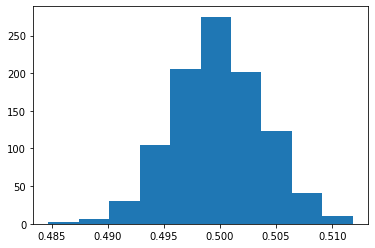

In [167]:
plt.hist(test)

In [140]:
(test >= .99).sum()

0